<a href="https://colab.research.google.com/github/sameedrt/CarDamageDetector/blob/main/Car_Damage_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive #for this project I have stored my dataset on google drive
import zipfile
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/CarDD/CarDD_release.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # List all files/folders inside the zip
    files = zip_ref.namelist()
    for f in files[:20]:  # Since we have so many files I am just going to print out the first 20
        print(f)

Mounted at /content/drive
CarDD_release/
CarDD_release/CarDD_COCO/
CarDD_release/CarDD_COCO/annotations/
CarDD_release/CarDD_COCO/annotations/image_info.xlsx
CarDD_release/CarDD_COCO/annotations/instances_test2017.json
CarDD_release/CarDD_COCO/annotations/instances_train2017.json
CarDD_release/CarDD_COCO/annotations/instances_val2017.json
CarDD_release/CarDD_COCO/test2017/
CarDD_release/CarDD_COCO/test2017/000012.jpg
CarDD_release/CarDD_COCO/test2017/000015.jpg
CarDD_release/CarDD_COCO/test2017/000023.jpg
CarDD_release/CarDD_COCO/test2017/000033.jpg
CarDD_release/CarDD_COCO/test2017/000040.jpg
CarDD_release/CarDD_COCO/test2017/000042.jpg
CarDD_release/CarDD_COCO/test2017/000044.jpg
CarDD_release/CarDD_COCO/test2017/000057.jpg
CarDD_release/CarDD_COCO/test2017/000082.jpg
CarDD_release/CarDD_COCO/test2017/000088.jpg
CarDD_release/CarDD_COCO/test2017/000090.jpg
CarDD_release/CarDD_COCO/test2017/000106.jpg


In [8]:
#Now i am going to unzip the folder:
!unzip -q '/content/drive/MyDrive/CarDD/CarDD_release.zip' -d '/content/car_dd'


In [6]:
base_path = '/content/car_dd/CarDD_release/CarDD_COCO'

train_images_dir = base_path + '/train2017'
val_images_dir = base_path + '/val2017'
test_images_dir = base_path + '/test2017'
annotations_dir = base_path + '/annotations'


In [9]:
import os

print("Train images:", os.listdir(train_images_dir)[:5])
print("Val images:", os.listdir(val_images_dir)[:5])
print("Test images:", os.listdir(test_images_dir)[:5])
print("Annotations files:", os.listdir(annotations_dir))


Train images: ['002710.jpg', '000709.jpg', '000921.jpg', '000569.jpg', '002247.jpg']
Val images: ['000445.jpg', '000356.jpg', '002206.jpg', '001702.jpg', '001245.jpg']
Test images: ['001587.jpg', '003743.jpg', '000090.jpg', '000057.jpg', '003671.jpg']
Annotations files: ['instances_test2017.json', 'image_info.xlsx', 'instances_train2017.json', 'instances_val2017.json']


loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


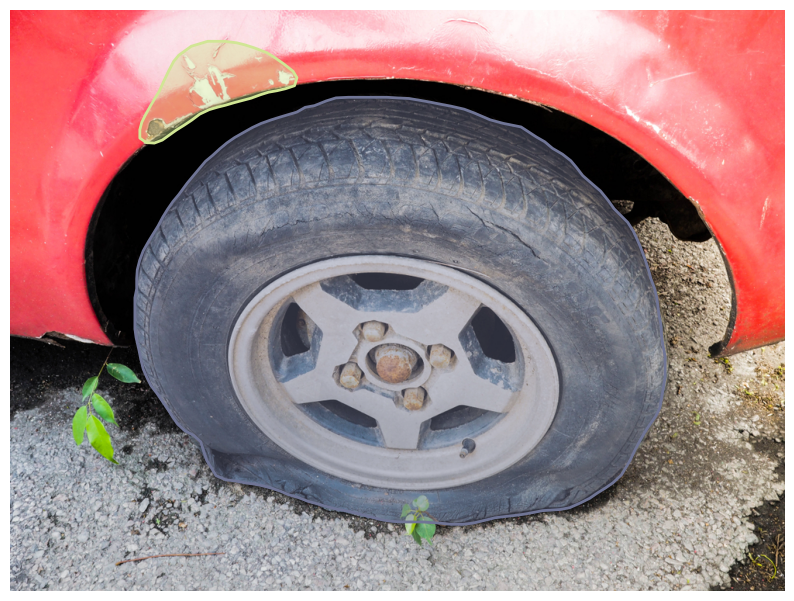

In [10]:
from pycocotools.coco import COCO
import os
import cv2
import matplotlib.pyplot as plt


train_ann_file = os.path.join(annotations_dir, 'instances_train2017.json')
coco_train = COCO(train_ann_file)


# Get a list of image IDs from the train set
img_ids = coco_train.getImgIds()

# Load one image and display it with annotations
img_id = img_ids[0]
img_info = coco_train.loadImgs(img_id)[0]
img_path = os.path.join(train_images_dir, img_info['file_name'])

# Read image
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('off')

# Load and display annotations (bounding boxes, masks, etc.)
ann_ids = coco_train.getAnnIds(imgIds=img_id)
anns = coco_train.loadAnns(ann_ids)
coco_train.showAnns(anns)

plt.show()

In [11]:
#Now the next step would be to convert the COCO format to YOLO format
import json
from PIL import Image
from tqdm import tqdm

base_dir = "/content/car_dd/CarDD_release/CarDD_COCO"

output_dir = "/content/CarDD_YOLO"
os.makedirs(output_dir, exist_ok=True)

def COCO_to_YOLO(bbox, img_width, img_height):
  x,y,w,h = bbox
  x_centre = (x + w/2)/img_width
  y_centre = (y+h /2)/ img_height
  w /= img_width
  h /= img_height
  return [x_centre, y_centre, w, h]


def convert_split(split):
    ann_file = os.path.join(base_dir, 'annotations', f'instances_{split}2017.json')
    img_dir = os.path.join(base_dir, f'{split}2017')
    label_dir = os.path.join(output_dir, f'labels/{split}')
    image_out_dir = os.path.join(output_dir, f'images/{split}')
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(image_out_dir, exist_ok=True)

    with open(ann_file) as f:
        data = json.load(f)

    categories = {cat['id']: i for i, cat in enumerate(data['categories'])}
    images = {img['id']: img for img in data['images']}

    ann_map = {}
    for ann in data['annotations']:
        img_id = ann['image_id']
        if img_id not in ann_map:
            ann_map[img_id] = []
        ann_map[img_id].append(ann)

    for img_id, anns in tqdm(ann_map.items(), desc=f'Converting {split} set'):
        file_name = images[img_id]['file_name']
        img_path = os.path.join(img_dir, file_name)
        image = Image.open(img_path)
        img_width, img_height = image.size

        label_lines = []
        for ann in anns:
            coco_bbox = ann['bbox']
            yolo_bbox = COCO_to_YOLO(coco_bbox, img_width, img_height)
            class_id = categories[ann['category_id']]
            label_line = f"{class_id} " + " ".join(f"{x:.6f}" for x in yolo_bbox)
            label_lines.append(label_line)

        # Save image
        image.save(os.path.join(image_out_dir, file_name))

        # Save label
        label_file = os.path.join(label_dir, file_name.replace('.jpg', '.txt'))
        with open(label_file, 'w') as f:
            f.write("\n".join(label_lines))

# Run for train, val, and test
convert_split('train')
convert_split('val')
convert_split('test')



Converting test set: 100%|██████████| 374/374 [00:07<00:00, 48.47it/s]


In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17488, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 17488 (delta 0), reused 0 (delta 0), pack-reused 17486 (from 2)
Receiving objects: 100% (17488/17488), 16.55 MiB | 28.34 MiB/s, done.
Resolving deltas: 100% (11995/11995), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:0

In [7]:
import json

with open('/content/car_dd/CarDD_release/CarDD_COCO/annotations/instances_train2017.json') as f:
    data = json.load(f)

categories = data['categories']
for cat in categories:
    print(f"{cat['id']}: {cat['name']}")

print(f"\nTotal number of classes: {len(categories)}")


1: dent
2: scratch
3: crack
4: glass shatter
5: lamp broken
6: tire flat

Total number of classes: 6


In [3]:
data_yaml = """
train: /content/CarDD_YOLO/images/train
val: /content/CarDD_YOLO/images/val

nc: 6
names: ['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken' ,'tire flat']  # Replace with actual class names
"""

with open("data.yaml", "w") as f:
    f.write(data_yaml)

print("data.yaml file created successfully!")


data.yaml file created successfully!


In [12]:
!python train.py --img 640 --batch 16 --epochs 30 --data /content/yolov5/data.yaml --weights yolov5s.pt --cache


Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      16/29      4.95G    0.04296    0.03304   0.009511         77        640:   4% 7/176 [00:01<00:43,  3.93it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      16/29      4.95G    0.04229    0.03315   0.008988         82        640:   5% 8/176 [00:02<00:42,  3.91it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      16/29      4.95G    0.04253    0.03331   0.008811         78        640:   5% 9/176 [00:02<00:42,  3.90it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):


In [14]:
!python detect.py --weights runs/train/exp2/weights/best.pt --img 640 --conf 0.25 --source /content/CarDD_YOLO/images/test


detect: weights=['runs/train/exp2/weights/best.pt'], source=/content/CarDD_YOLO/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-420-g0c99ce80 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
image 1/374 /content/CarDD_YOLO/images/test/000012.jpg: 448x640 1 tire flat, 28.5ms
image 2/374 /content/CarDD_YOLO/images/test/000015.jpg: 448x640 1 scratch, 9.0ms
image 3/374 /content/CarDD_YOLO/images/test/000023.jpg: 448x640 1 dent, 1 scratch, 12.7ms
image 4/374 /content/CarDD_YOLO/images/test/00

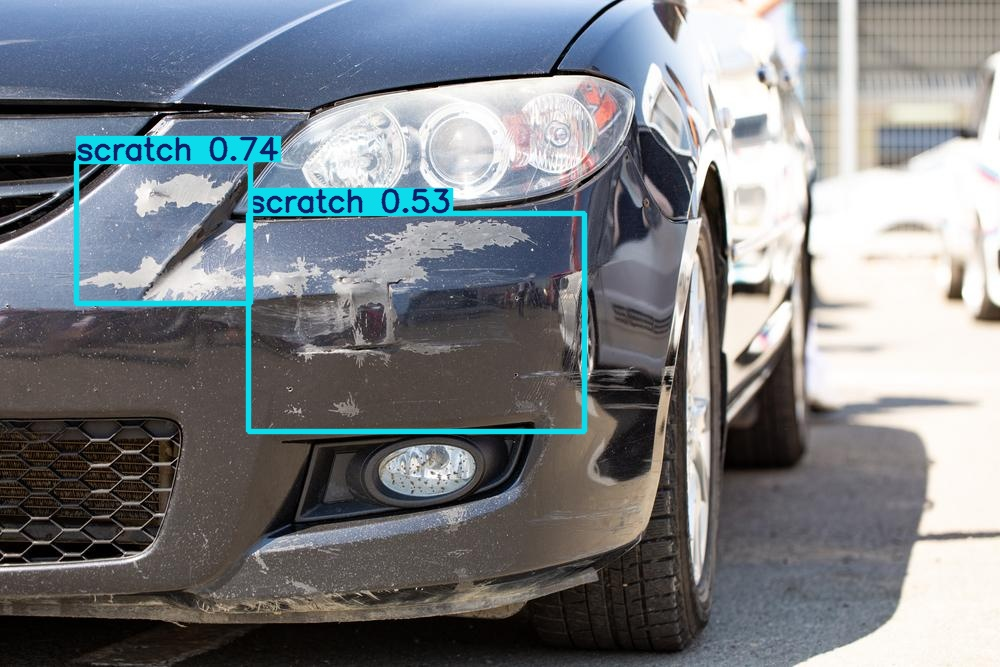

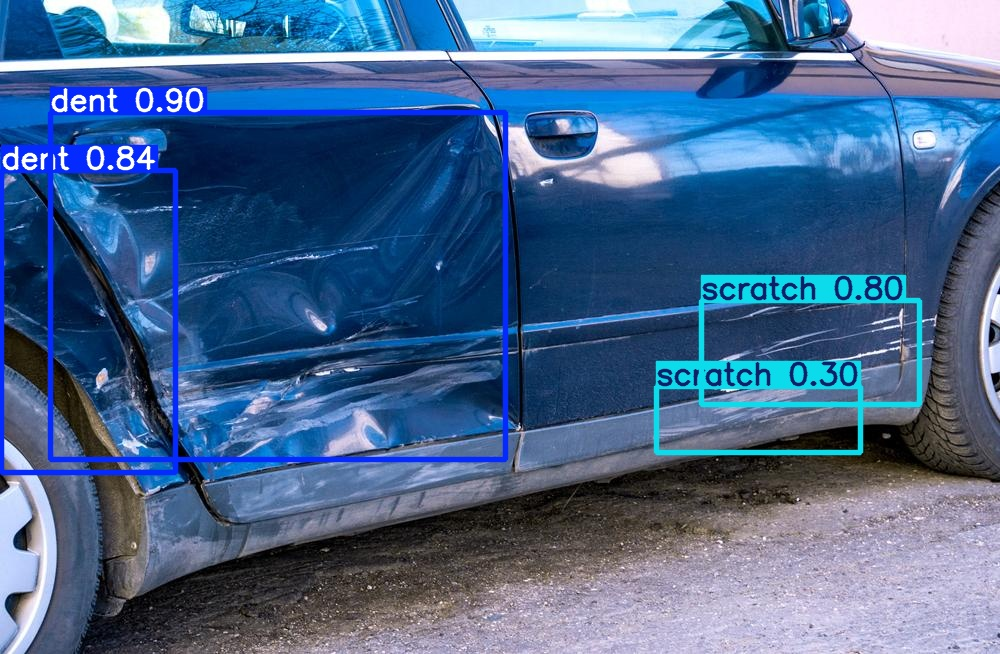

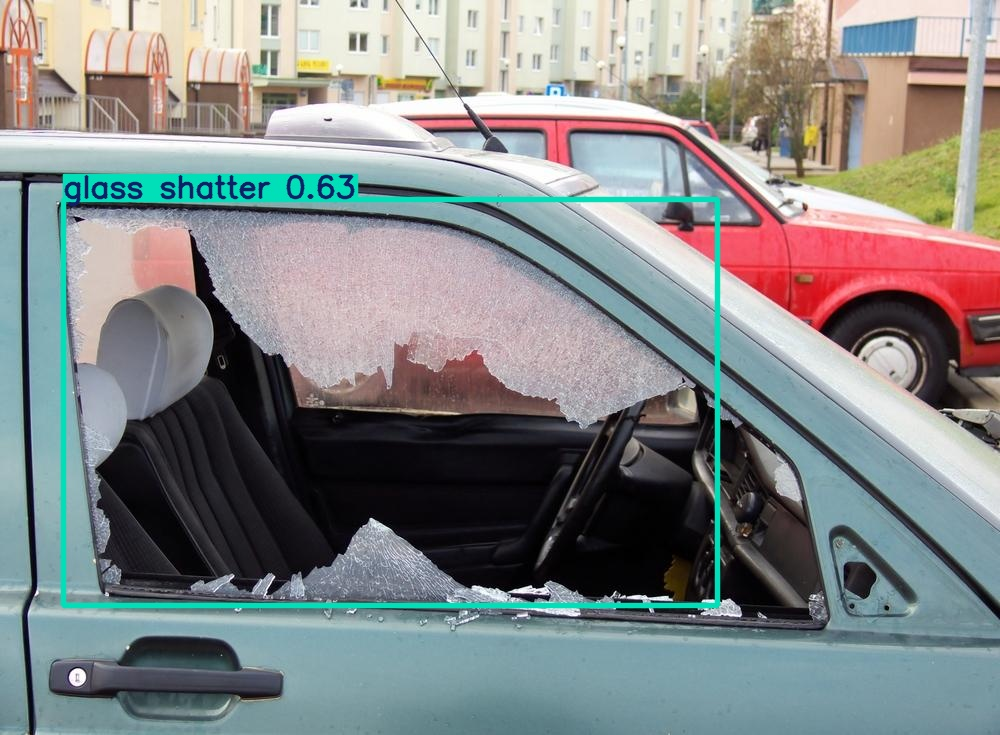

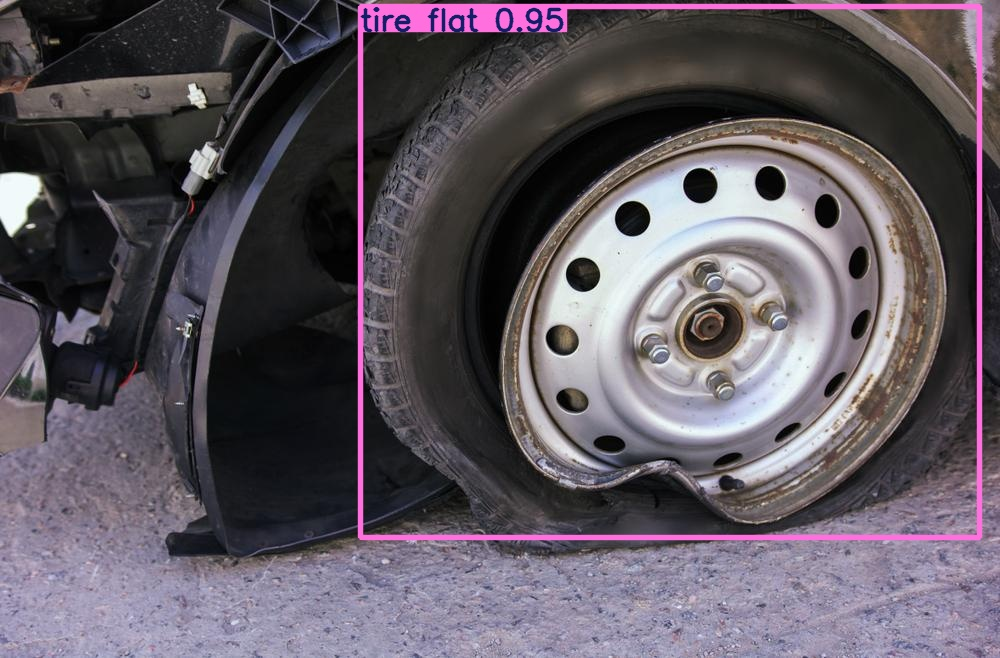

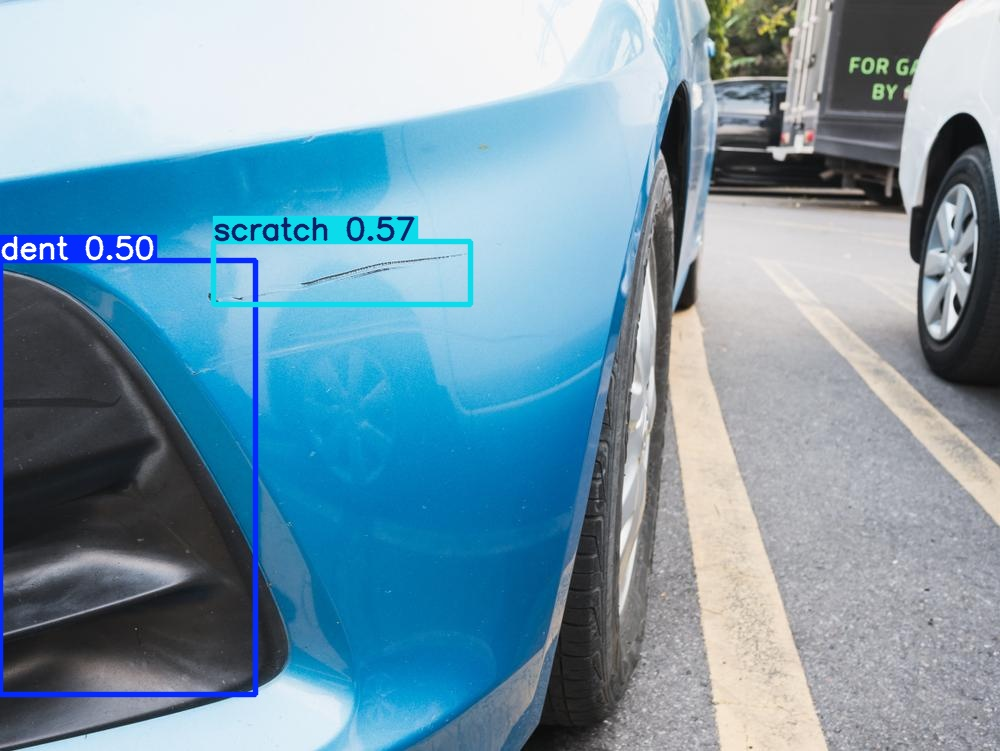

In [15]:
from IPython.display import Image, display
import glob

for img_path in glob.glob('runs/detect/exp/*.jpg')[:5]:
    display(Image(filename=img_path))


In [16]:
!cp runs/train/exp2/weights/best.pt /content/drive/MyDrive/CarDD/


In [53]:
from google.colab import files
uploaded = files.upload()




Saving smashedwindow.jpg to smashedwindow.jpg


detect: weights=['runs/train/exp2/weights/best.pt'], source=smashedwindow.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-420-g0c99ce80 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7026307 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/yolov5/smashedwindow.jpg: 480x640 1 glass shatter, 29.9ms
Speed: 0.6ms pre-process, 29.9ms inference, 125.2ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp11


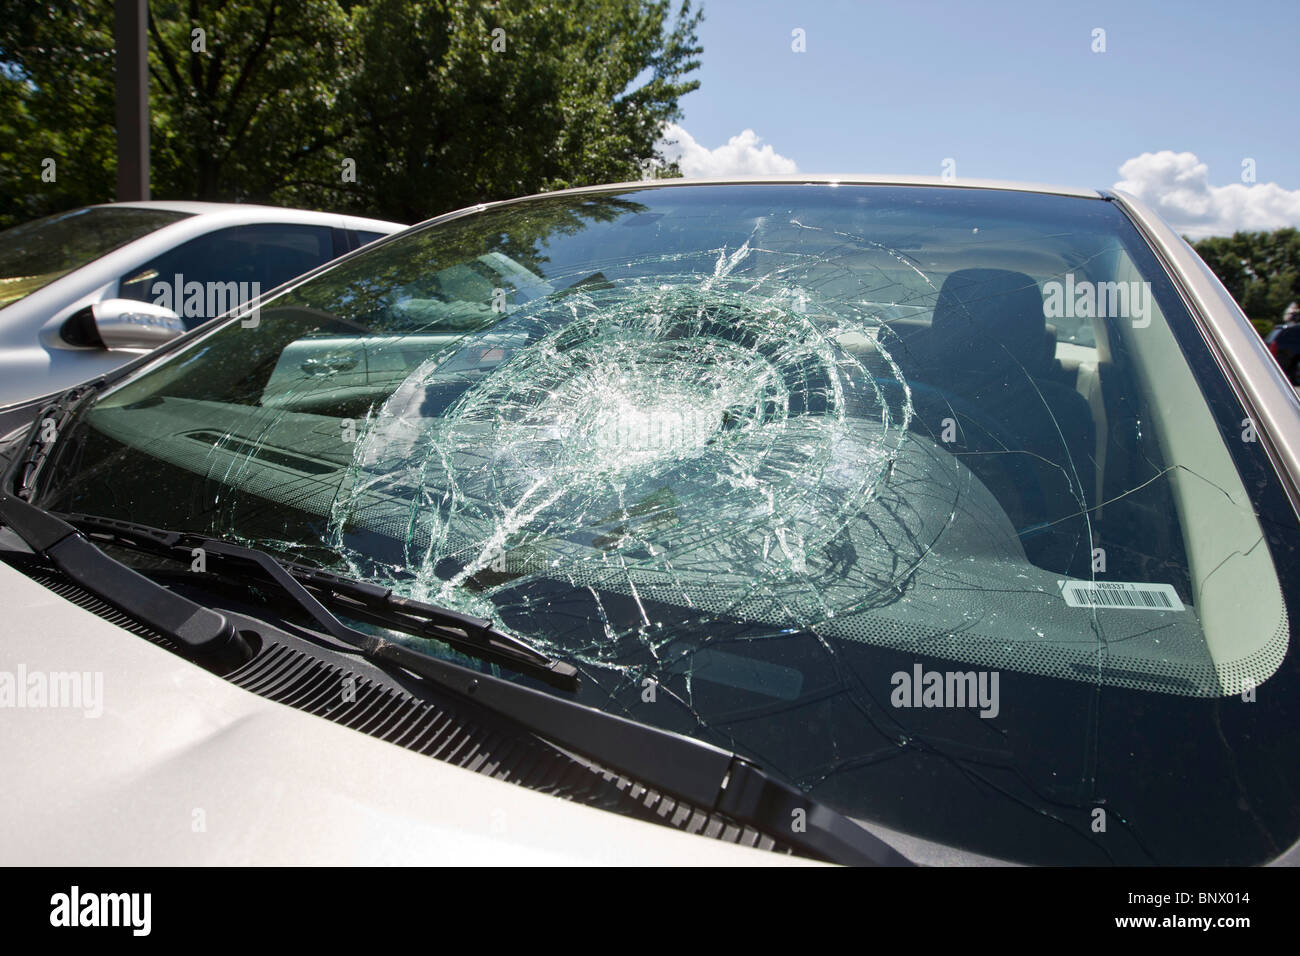

In [54]:
!python detect.py --weights runs/train/exp2/weights/best.pt --img 640 --conf 0.1 --source smashedwindow.jpg

from IPython.display import Image
Image('smashedwindow.jpg')  # Replace with the actual output filename (usually same as input)



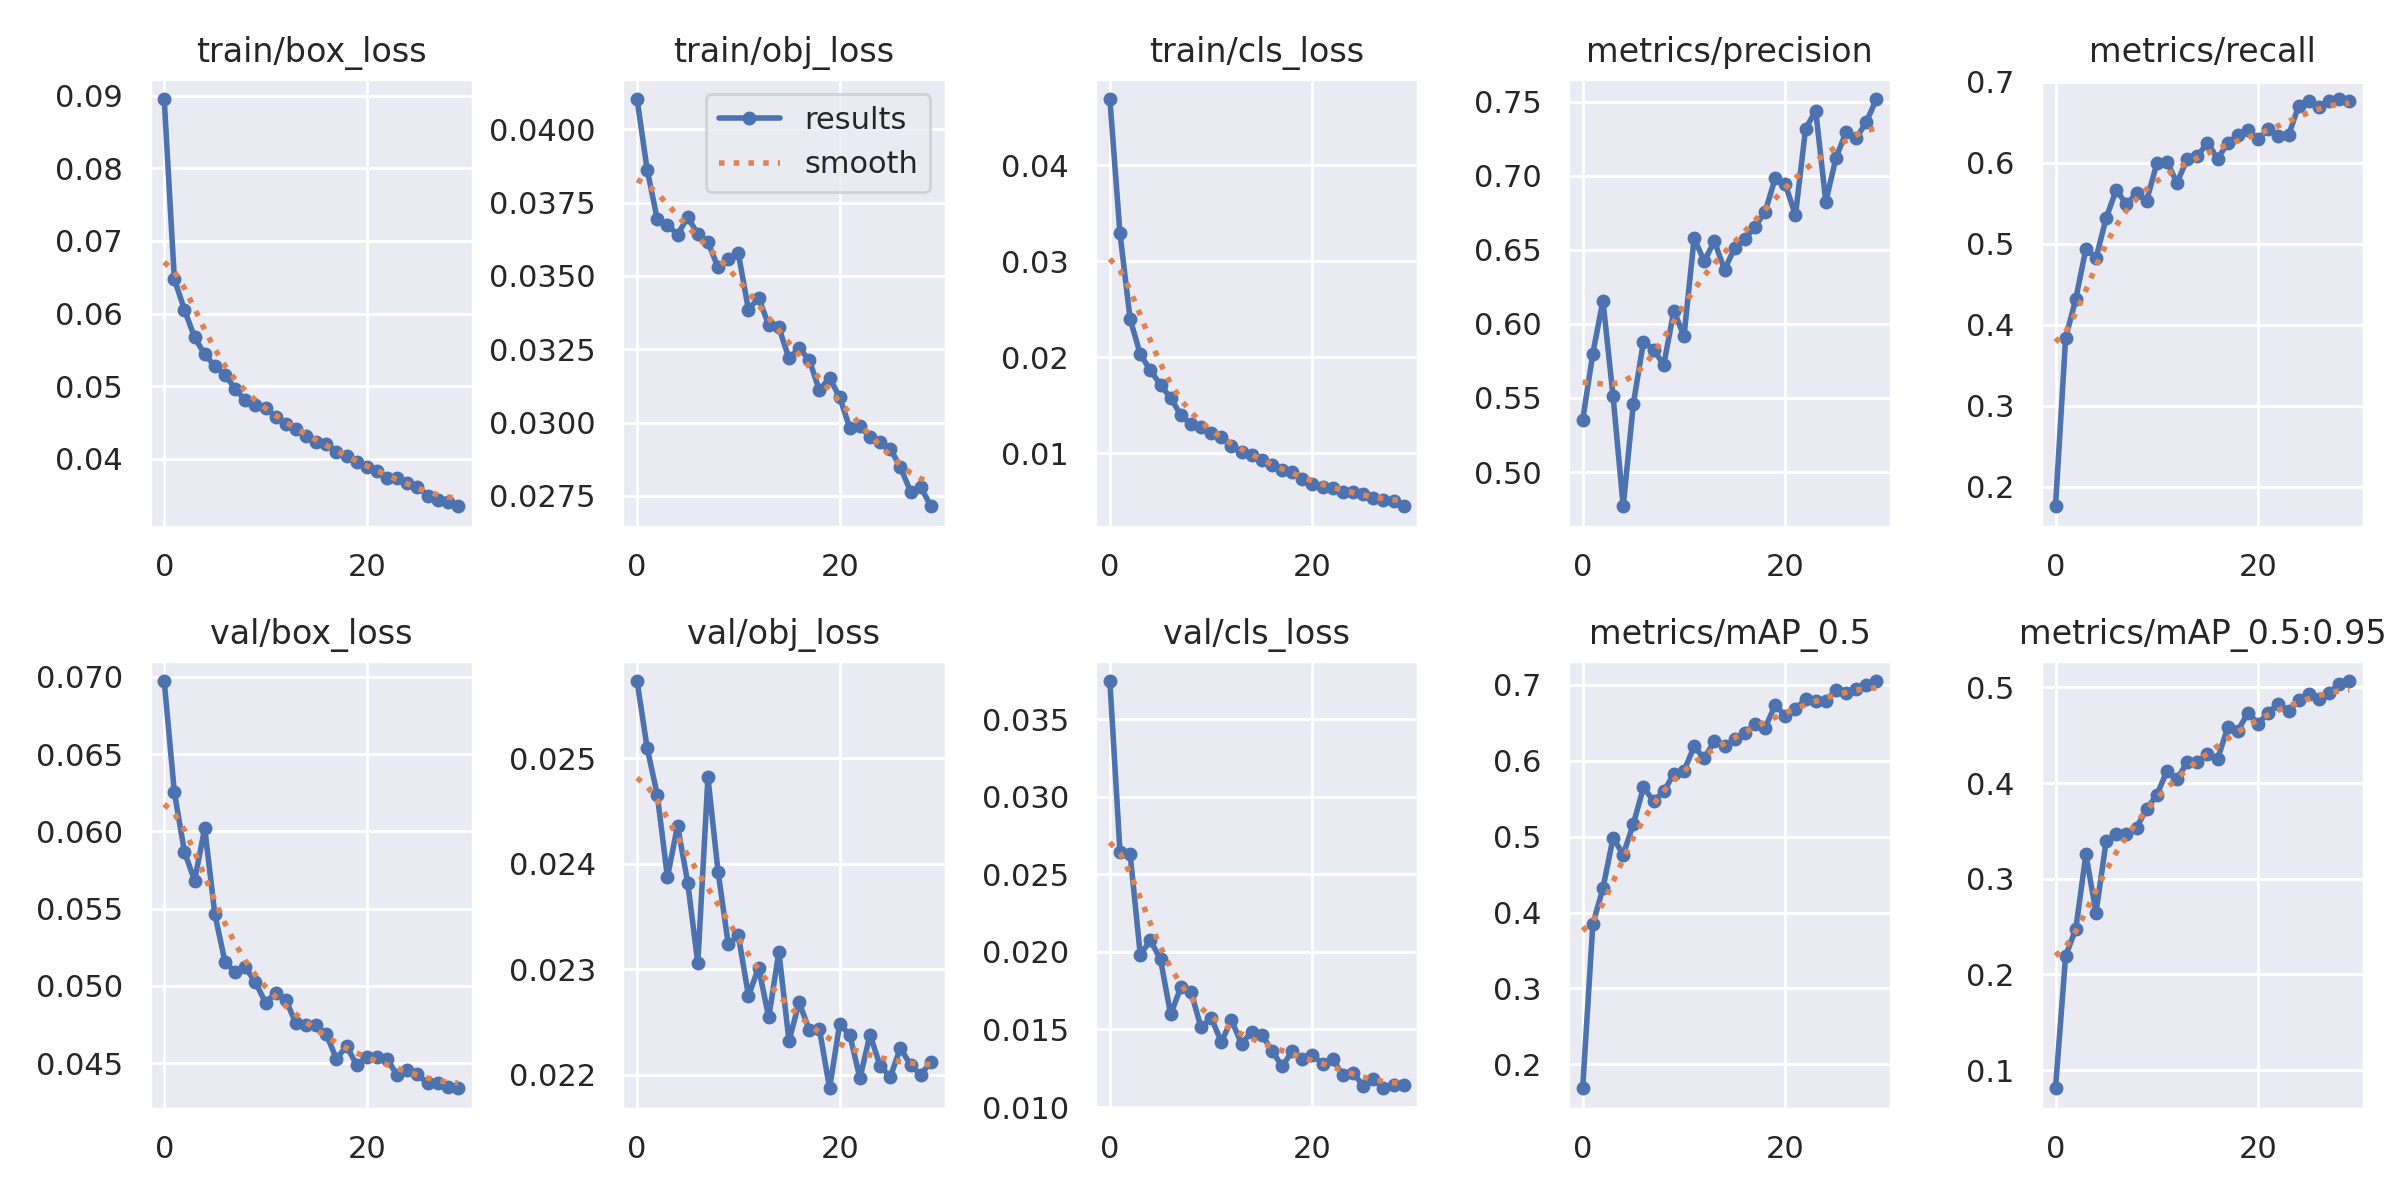

In [52]:
from IPython.display import Image, display

# Show training result graph
display(Image(filename='runs/train/exp2/results.png'))


In [57]:
!git config --global user.name "sameedrt"
!git config --global user.email "ahmedalisameed@gmail.com"
